### Trying to create a clothing line using GAN

#### steps
- Load Data: TFDS, Mnist dataset
- Build Generator: generate a 28 by 28 image
- Discriminator: will see if image is real or fake: 0:true, 1:fake
- take generated image and send to discriminator with the real images

In [ ]:
# Import dependencies and data
!pip install ipywidgets

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import ipywidgets

In [2]:
! pip install tensorflow-datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
for gpu in gpus:
  print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
# will use fashion_mnist data
dataset = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.VEXIZ5_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.VEXIZ5_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [6]:
type(dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [5]:
dataset.as_numpy_iterator().next()['label']

2

### Visualize data and Build data pipeline

In [6]:
import numpy as np #data transformation

In [7]:
#setup connection aka iterator
data_iterator = dataset.as_numpy_iterator()

In [8]:
# getting data out of the pipeline
np.squeeze(data_iterator.next()['image']).shape #everytime we run this we get back new dataset, essentially helping in nn generalization and memory management

(28, 28)

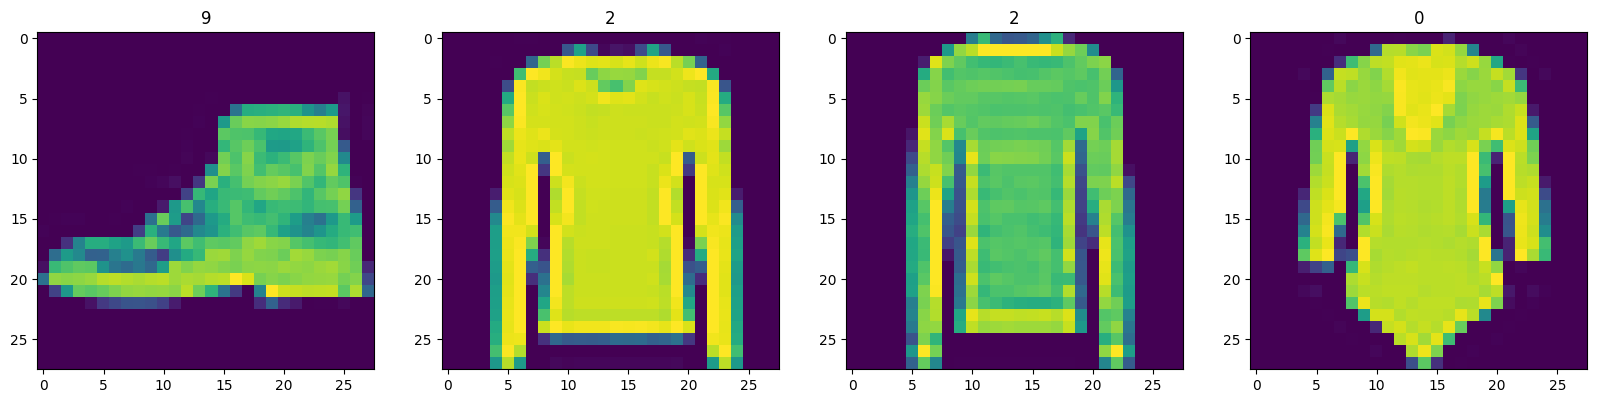

In [56]:
# create some subplots to visualize a few images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
  batch = data_iterator.next()
  ax[idx].imshow(np.squeeze(batch['image']))
  ax[idx].title.set_text(batch['label'])

In [10]:
ax[0].imshow()

TypeError: Axes.imshow() missing 1 required positional argument: 'X'

In [11]:
# scale our images from 0-255 to 0-1 just helps the model perform better
def image_scaler(data):
  image = data['image']
  return image/255

#### PIPELINE

In [ ]:
### Steps for data pipeline for tensorflow generally
#1 map
#2 cache
#3 shuffle
#4 batch
#5 prefetch

In [12]:
ds = tfds.load('fashion_mnist', split = 'train')
ds = ds.map(image_scaler)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [13]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

#### Build Neural Network
- import modelling component
- build generator
- build discriminator

In [14]:
# Bring in the sequntial API for the generator and the discriminator and the layers for the neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [15]:
# Build Generator

def build_generator():
  model = Sequential()

  # takes random values and reshapes to 7*7*128
  # beginnings of a generated image
  model.add(Dense(7*7*128, input_dim = 128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  #Upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128,5, padding = 'same')) # cnn model will have 128 units, 5x5 filters and similar padding as block 1
  model.add(LeakyReLU(0.2))

  # upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128,5, padding = 'same')) # cnn model will have 128 units, 5x5 filters and similar padding as block 1
  model.add(LeakyReLU(0.2))

  # Convolutional block 1
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  # Convolutional block 2
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  #Conv layer to get to one channel
  model.add(Conv2D(1,4,padding = 'same', activation = 'sigmoid'))

  return model

In [16]:
generator = build_generator()

In [17]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [27]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 20ms/step


In [28]:
img.shape

(4, 28, 28, 1)

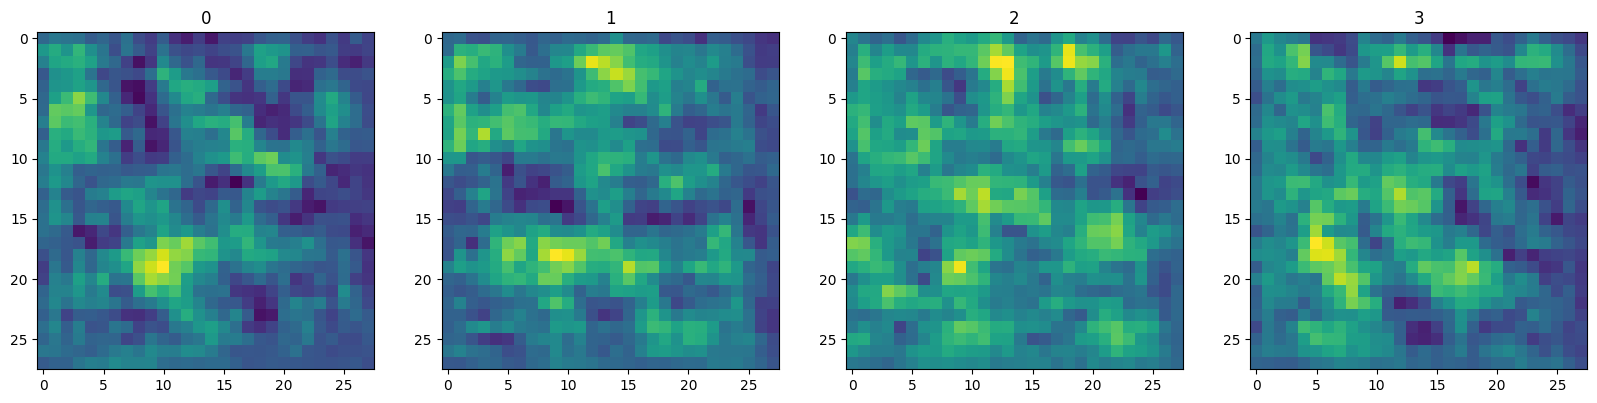

In [20]:
# create some subplots to visualize a few images (ofcourse these images are not at all well defined because we are yet to train them)
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(img):
  ax[idx].imshow(np.squeeze(img))
  ax[idx].title.set_text(idx)

In [21]:
# Build Discriminator (nothing but an image classifier trying to find true vs fake)

def build_discriminator():
  model = Sequential()

  # First conv block
  model.add(Conv2D(32,5,input_shape = (28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Second conv block
  model.add(Conv2D(64,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Third conv block
  model.add(Conv2D(128,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Fourth conv block
  model.add(Conv2D(256,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Flatten and pass to dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation = 'sigmoid'))

  return model

In [22]:
discriminator = build_discriminator()

In [23]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [24]:
img.shape

(28, 28, 1)

In [33]:
discriminator.predict(img)

1/1 [==============================] - 0s 19ms/step


array([[0.50681776],
       [0.50674963],
       [0.50671786],
       [0.506579  ]], dtype=float32)

#### Construct Training Loop
- setup losss and optimizers
- build subclass model
- build callback
- train
- review performance

In [30]:
# setup losses and optimizers (we will use binary cross entropy loss for both and adam optimizer)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [31]:
# create instances of them
g_opt = Adam(learning_rate = 0.0001) #generator optimizer
d_opt = Adam(learning_rate = 0.00001) #dicsriminator optimizer
# losses now
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [34]:
# subclass model building now
# import the base model class to subclass out training step
from tensorflow.keras.models import Model

In [44]:
class FashionGAN(Model):

  def __init__(self, generator, discriminator, *args, **kwargs):
    # pass through args and kwargs through base class
    super().__init__(*args, **kwargs)
    # create attributes for gen and discr
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    # compile with the base class
    super().compile(*args,**kwargs)
    # create attributes for losses and optimizers
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss

  def train_step(self, batch):
    # get the data
    real_images = batch
    fake_images = self.generator(tf.random.normal((128, 128, 1)), training = False)

    # train the discriminator
    # pass the real and fake images to model then create labels for real and fake imgs, then pass through or add some noise to the outputs, calculate the loss, apply backpropagation
    with tf.GradientTape() as d_tape:
      yhat_real = self.discriminator(real_images, training = True)
      yhat_fake = self.discriminator(fake_images, training = True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis = 0)

      # create labels
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis = 0)

      # add noise
      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real, noise_fake], axis=0)

      # calc loss
      total_d_loss = self.d_loss(y_realfake, yhat_realfake)

    # backpropagation
    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

    # train generator
    with tf.GradientTape() as g_tape:
      # generate new images
      gen_images = self.generator(tf.random.normal((128,128,1)), training = True)
      # create the predicted labels
      predicted_labels = self.discriminator(gen_images, training = False)
      # calc loss - trick to training to fake out the discriminator
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

    # backpropagation
    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

    return {"d_loss": total_d_loss, "g_loss": total_g_loss}

In [45]:
fashgan = FashionGAN(generator, discriminator)

In [46]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [39]:
# Build callback
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [49]:
class ModelMonitor(Callback):
    def _init_(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [42]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [ ]:
# Train the models now for recommended 2000 epochs
hist = fashgan.fit(ds, epochs = 100 #,callbacks = [ModelMonitor()]
                   )

Epoch 1/100
469/469 [==============================] - 78s 165ms/step - d_loss: 0.3211 - g_loss: 0.0132
Epoch 2/100
469/469 [==============================] - 78s 165ms/step - d_loss: 0.3111 - g_loss: 0.0189
Epoch 3/100
469/469 [==============================] - 77s 165ms/step - d_loss: 0.3063 - g_loss: 0.0245
Epoch 4/100
469/469 [==============================] - 78s 166ms/step - d_loss: 0.3034 - g_loss: 0.0255
Epoch 5/100
469/469 [==============================] - 78s 165ms/step - d_loss: 0.2942 - g_loss: 0.0201
Epoch 6/100
469/469 [==============================] - 78s 166ms/step - d_loss: 0.5667 - g_loss: 0.2656
Epoch 7/100
469/469 [==============================] - 78s 165ms/step - d_loss: 0.6806 - g_loss: 0.5506
Epoch 8/100
469/469 [==============================] - 77s 165ms/step - d_loss: 0.6386 - g_loss: 0.5633
Epoch 9/100
469/469 [==============================] - 78s 165ms/step - d_loss: 0.6820 - g_loss: 0.5297
Epoch 10/100
469/469 [==============================] - 77s 165m

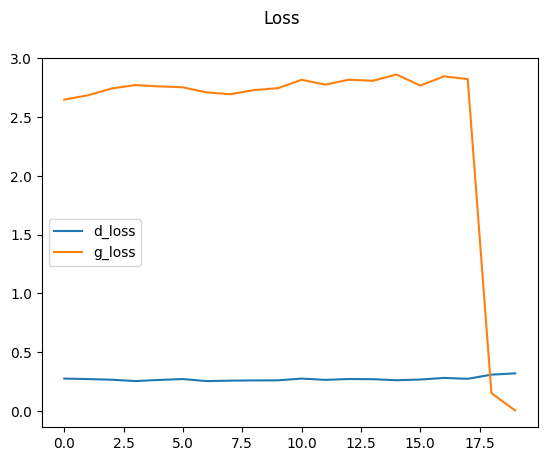

In [53]:
# Review Performance
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [54]:
# Generate Images to Test out the Model
imgs = generator.predict(tf.random.normal((16, 128, 1)))
imgs

1/1 [==============================] - 0s 468ms/step


array([[[[0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         ...,
         [2.39321403e-03],
         [0.00000000e+00],
         [1.00000000e+00]],

        [[7.20205157e-21],
         [0.00000000e+00],
         [0.00000000e+00],
         ...,
         [0.00000000e+00],
         [0.00000000e+00],
         [1.00000000e+00]],

        [[1.50356001e-25],
         [0.00000000e+00],
         [0.00000000e+00],
         ...,
         [0.00000000e+00],
         [0.00000000e+00],
         [1.00000000e+00]],

        ...,

        [[5.64193391e-33],
         [1.60044831e-37],
         [0.00000000e+00],
         ...,
         [0.00000000e+00],
         [0.00000000e+00],
         [1.00000000e+00]],

        [[1.04297229e-18],
         [3.38785861e-18],
         [2.03804520e-21],
         ...,
         [0.00000000e+00],
         [2.08629970e-33],
         [1.00000000e+00]],

        [[8.31892900e-03],
         [9.99999881e-01],
         [1.00000000e+00],
         ...,
 

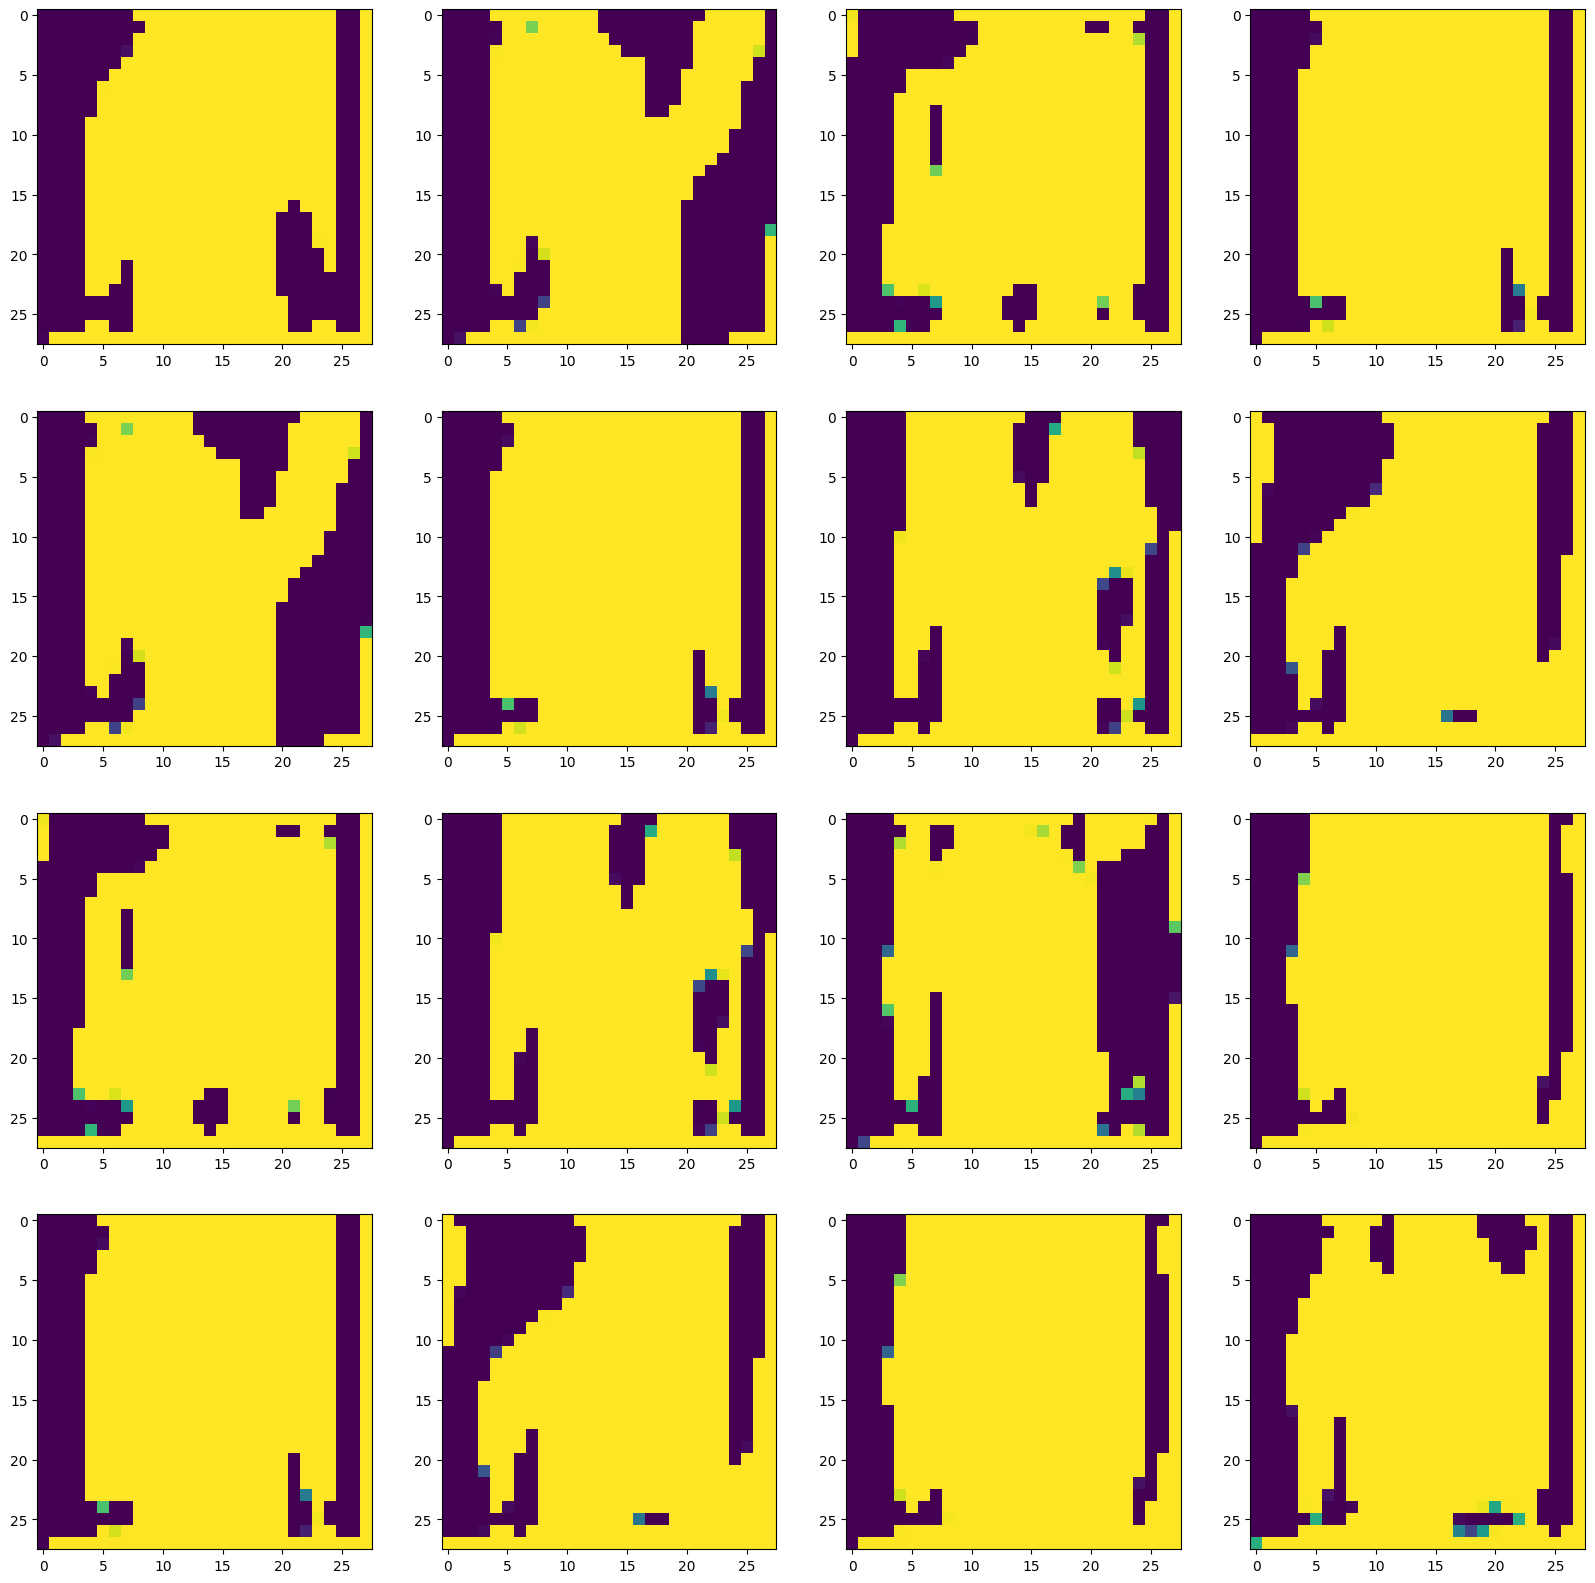

In [55]:
fig, ax = plt.subplots(ncols = 4, nrows = 4, figsize=(20,20))
for r in range(4):
  for c in range(4):
    ax[r][c].imshow(imgs[(r+1)*(c+1)-1])